In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# !pip install --upgrade --user scikit-learn

In [3]:
df = pd.read_csv("data/train_dataset.csv",index_col=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                3216 non-null   int64  
 1   Unnamed: 0.1              3216 non-null   int64  
 2   key                       3216 non-null   object 
 3   ID                        3216 non-null   float64
 4   create_date               3216 non-null   object 
 5   user                      3216 non-null   object 
 6   userID                    3216 non-null   float64
 7   RT_TF                     3216 non-null   bool   
 8   full_text                 3216 non-null   object 
 9   Sample.ID.x               3216 non-null   int64  
 10  Sample.ID.y               3216 non-null   int64  
 11  Still.Exists.x            3216 non-null   bool   
 12  Still.Exists.y            3216 non-null   bool   
 13  In.English.x              3216 non-null   bool   
 14  In.Engli

In [5]:
def memreduce(df):
    mem_before = df.memory_usage().sum() / 1024**2
    print("Memory Usage of DataFrame is "+ str(mem_before))
    for col in df.columns:
        coltype=df[col].dtype
        if coltype!=object:
            c_min=df[col].min()
            c_max=df[col].max()
            if(str(coltype)[:3]=='int'):
                if(c_min>=np.iinfo(np.int8).min and c_max<=np.iinfo(np.int8).max):
                    df[col]=df[col].astype(np.int8)
                elif(c_min>=np.iinfo(np.int16).min and c_max<=np.iinfo(np.int16).max):
                    df[col]=df[col].astype(np.int16)
                elif(c_min>=np.iinfo(np.int16).min and c_max<=np.iinfo(np.int16).max):
                    df[col]=df[col].astype(np.int16)
                    
            elif(str(coltype)[:5]=='float'):
                if(c_min>=np.finfo(np.float16).min and c_max<=np.finfo(np.float16).max):
                    df[col]=df[col].astype(np.float16)
                elif(c_min>=np.finfo(np.float32).min and c_max<=np.finfo(np.float32).max):
                    df[col]=df[col].astype(np.float32)
    mem_before = df.memory_usage().sum() / 1024**2
    print("Memory Usage of DataFrame after optimization is "+ str(mem_before))
    return df
                
                

In [6]:
df=memreduce(df)
gc.collect()

Memory Usage of DataFrame is 0.6656646728515625
Memory Usage of DataFrame after optimization is 0.3436279296875


23

In [7]:
df.head(10)

,Unnamed: 0,Unnamed: 0.1,key,ID,create_date,user,userID,RT_TF,full_text,Sample.ID.x,...,Calling.Out.x,Calling.Out.y,Is.About.the.Holocaust.x,Is.About.the.Holocaust.y,IHRA.Section.x,IHRA.Section.y,sample_name,Is.About.The.Holocaust.x,Is.About.The.Holocaust.y,Target
0,2454,2454,JewNAS,1.232290e+18,Tue Feb 25 07:54:26 -0500 2020,Leafy13222544,1.209270e+18,True,@ShaKeeL__007 @marksul44 @P3ng1z @BernieSander...,366,...,1,0,0.0,0.0,13,13,Jews2020Jan-Apr.rep2,NaN,NaN,0
1,870,870,JewAS,1.272910e+18,Tue Jun 16 11:13:24 -0400 2020,sharonka3,9.752547e+08,True,This is a perfect example of how Jews across N...,68,...,0,0,NaN,NaN,2,2,Jews2020May-Aug.rep1.rep1,0.0,0.0,1
2,763,763,JewAS,1.233040e+18,Thu Feb 27 09:53:39 -0500 2020,SpruceYelverton,1.114823e+09,True,Jews were the major cotton traders &amp; had n...,49,...,0,0,0.0,0.0,2,2,Jews2020Jan-Apr.rep1,NaN,NaN,1
3,3744,3744,KikesAS,1.202940e+18,Fri Dec 06 08:25:54 -0500 2019,plive_calmer,8.404970e+17,False,🙊 I bet #randum The media's slanted view of ki...,45,...,1,1,0.0,0.0,0,0,kikes2019.rep1,NaN,NaN,1
4,1525,1525,JewNAS,1.168870e+18,Tue Sep 03 08:53:53 -0400 2019,emzeekg,2.975341e+09,True,21 year old Palestinian woman murdered by her ...,186,...,0,1,0.0,0.0,13,13,Jews2019.rep2,NaN,NaN,0
5,2363,2363,JewNAS,1.231520e+18,Sun Feb 23 05:09:05 -0500 2020,mksharma4269,4.355702e+09,True,Those who’ve read or watched on media the hist...,246,...,0,0,1.0,1.0,13,13,Jews2020Jan-Apr.rep2,NaN,NaN,0
6,1737,1737,JewNAS,1.110570e+18,Tue Mar 26 11:42:27 -0400 2019,DrKlep,2.481168e+07,True,"In 2017, the Charlottesville rally of white su...",459,...,0,1,0.0,0.0,13,13,Jews2019.rep2,NaN,NaN,0
7,1436,1436,JewNAS,1.105120e+18,Mon Mar 11 11:02:53 -0400 2019,Noetic_Karma,5.166556e+07,False,Warning : Pakistan's state media have started ...,64,...,1,1,0.0,0.0,13,13,Jews2019.rep2,NaN,NaN,0
8,1322,1322,JewNAS,1.146550e+18,Wed Jul 03 18:34:35 -0400 2019,sagetwitting,3.257236e+09,True,Damn. What a statement.\n\n“Jews Against ICE: ...,408,...,0,0,1.0,0.0,13,13,Jews2019.rep1,NaN,NaN,0
9,1577,1577,JewNAS,1.115660e+18,Tue Apr 09 12:39:16 -0400 2019,Charlot38927993,2.793329e+09,True,“She (Congresswoman Omar) keeps on assaulting ...,250,...,0,0,0.0,0.0,13,13,Jews2019.rep2,NaN,NaN,0


In [8]:
def misval(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val = mis_val.rename(
        columns = {0 : 'Missing Values', 1 : 'per'})
        mis_val['Data Type'] = df.dtypes
        mis_val = mis_val[
            mis_val.iloc[:,1] != 0].sort_values('per', ascending=False).round(1)
        mis_val['per']=mis_val['per']
        mis_val['per']=mis_val['per'].astype(np.float16)
        
        return mis_val

sum_missing=misval(df)
sum_missing

,Missing Values,per,Data Type
Is.About.The.Holocaust.x,2264,70.37500,float16
Is.About.The.Holocaust.y,2264,70.37500,float16
Is.About.the.Holocaust.x,952,29.59375,float16
Is.About.the.Holocaust.y,952,29.59375,float16


## Correlation

In [9]:
corr_mat = df.corr(method='pearson')
upper_corr_mat = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
unique_corr_pairs = upper_corr_mat.unstack().dropna()
sorted_mat = unique_corr_pairs.sort_values()

cm=pd.DataFrame(sorted_mat)
cm=cm.loc[((cm[0]>-0.9) | (cm[0]<0.9)),:]
# df[df.index.str.contains('foo')]
cm.reset_index(inplace=True)

In [10]:
cm[cm['level_0'].str.contains('Target') | cm['level_1'].str.contains('Target') ]

,level_0,level_1,0
0,Target,IHRA.Section.y,-0.872644
1,Target,IHRA.Section.x,-0.729260
2,Target,Sentiment.Rating.y,-0.723462
3,Target,Sentiment.Rating.x,-0.571269
4,Target,RT_TF,-0.281357
7,Target,Calling.Out.x,-0.198643
10,Target,Is.About.the.Holocaust.x,-0.161212
11,Target,ID,-0.157218
12,Target,Calling.Out.y,-0.148500
16,Target,Still.Exists.x,-0.124562


# Pipeline

In [11]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

class Imputewithother(BaseEstimator, TransformerMixin):
    def __init__(self):
        super()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X=pd.DataFrame(X,columns=['a','b','c','d'])
        h1,h2,h3,h4='a','b','c','d'
        X[h1].fillna(X[h3],inplace=True)
        X[h2].fillna(X[h4],inplace=True)
        X.drop(columns=['c','d'],inplace=True)
        return X.values

In [13]:
y=df['Target']
X=df.drop(['Target'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

In [14]:
num_cols =list(X_train._get_numeric_data().columns)
catcols=list(set(X_train.columns) - set(num_cols))
print(num_cols,"\n")
print(catcols)

['Unnamed: 0', 'Unnamed: 0.1', 'ID', 'userID', 'RT_TF', 'Sample.ID.x', 'Sample.ID.y', 'Still.Exists.x', 'Still.Exists.y', 'In.English.x', 'In.English.y', 'Sarcasm.x', 'Sarcasm.y', 'Disagree.With.x', 'Disagree.With.y', 'Sentiment.Rating.x', 'Sentiment.Rating.y', 'Calling.Out.x', 'Calling.Out.y', 'Is.About.the.Holocaust.x', 'Is.About.the.Holocaust.y', 'IHRA.Section.x', 'IHRA.Section.y', 'Is.About.The.Holocaust.x', 'Is.About.The.Holocaust.y'] 

['User.x', 'create_date', 'full_text', 'Additional.Comments.x', 'key', 'sample_name', 'user', 'Additional.Comments.y', 'User.y']


In [15]:
[(i,v) for i,v in enumerate(list(X_train.columns))]

[(0, 'Unnamed: 0'),
 (1, 'Unnamed: 0.1'),
 (2, 'key'),
 (3, 'ID'),
 (4, 'create_date'),
 (5, 'user'),
 (6, 'userID'),
 (7, 'RT_TF'),
 (8, 'full_text'),
 (9, 'Sample.ID.x'),
 (10, 'Sample.ID.y'),
 (11, 'Still.Exists.x'),
 (12, 'Still.Exists.y'),
 (13, 'In.English.x'),
 (14, 'In.English.y'),
 (15, 'Sarcasm.x'),
 (16, 'Sarcasm.y'),
 (17, 'Additional.Comments.x'),
 (18, 'Additional.Comments.y'),
 (19, 'User.x'),
 (20, 'User.y'),
 (21, 'Disagree.With.x'),
 (22, 'Disagree.With.y'),
 (23, 'Sentiment.Rating.x'),
 (24, 'Sentiment.Rating.y'),
 (25, 'Calling.Out.x'),
 (26, 'Calling.Out.y'),
 (27, 'Is.About.the.Holocaust.x'),
 (28, 'Is.About.the.Holocaust.y'),
 (29, 'IHRA.Section.x'),
 (30, 'IHRA.Section.y'),
 (31, 'sample_name'),
 (32, 'Is.About.The.Holocaust.x'),
 (33, 'Is.About.The.Holocaust.y')]

In [16]:
pipedefault =['RT_TF','Still.Exists.x','Still.Exists.y','Sarcasm.x','Sarcasm.y','Disagree.With.x','Disagree.With.y',
              'Sentiment.Rating.x','Sentiment.Rating.y','Calling.Out.x','Calling.Out.y']

pipefilter1 = ['Is.About.the.Holocaust.x', 'Is.About.the.Holocaust.y','Is.About.The.Holocaust.x', 'Is.About.The.Holocaust.y']
pipefilter2 = ['IHRA.Section.x','IHRA.Section.y','sample_name','key']

pipe0 = Pipeline([
        ('selector', DataFrameSelector(pipedefault)),
    ])

pipe1 = Pipeline([
        ('selector', DataFrameSelector(pipefilter1)),
        ('Imputewithother', Imputewithother()),
        ('imputer', SimpleImputer(strategy='median')),
    ])

pipe2 = Pipeline([
        ('selector', DataFrameSelector(pipefilter2)),
        #('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])

data_prep_pipeline = FeatureUnion(transformer_list=[
        ("pipe0", pipe0),
        ("pipe1", pipe1),
        ("pipe2", pipe2),
    ])

In [17]:
gc.collect()

90

In [35]:
try:
    expLog
except NameError:
    expLog = pd.DataFrame(columns=["exp_name", 
                                   "Train Acc", 
                                   "Test  Acc",
                                   "Train AUC", 
                                   "Test  AUC",
                                   "Train F1",
                                   "Test F1"
                                  ])

In [77]:
def addresultotable(model,name):
    exp_name = name
    expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
                   [accuracy_score(y_train, model.predict(X_train)), 
                    accuracy_score(y_test, model.predict(X_test)),
                    roc_auc_score(y_train, model.predict(X_train)),
                    roc_auc_score(y_test, model.predict(X_test)),
                    f1_score(y_train, model.predict(X_train), average='weighted'),
                    f1_score(y_test, model.predict(X_test), average='weighted')],
        4)) 
    
def plotConf(model):
    plt.clf()
    plot_confusion_matrix(model, X_train, y_train)
    plt.title('Confusion Matrix ')
    plt.show()

def plotROC(model):
    RocCurveDisplay.from_predictions(y_test, model.predict(X_test))
    plt.show()

def trainmodel(regressor,datapipeline,paramgrid,scoring):
    pipe = Pipeline([
        ("preparation", datapipeline),
        ("reg", regressor)
    ])
    model=RandomizedSearchCV(pipe,param_distributions=paramgrid,n_iter=10,scoring=scoring,n_jobs=-1,cv=5,verbose=2)
    model.fit(X_train,y_train)
    return model

In [37]:
MODELS={}

# XGBoost

Fitting 5 folds for each of 10 candidates, totalling 50 fits


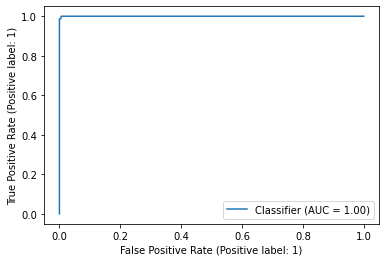

C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

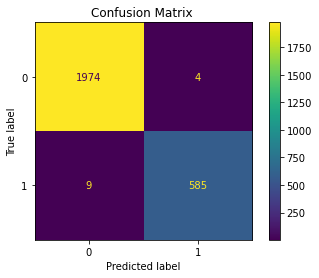

In [38]:
parameters = {
    "reg__loss":["deviance"],
    "reg__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "reg__min_samples_split": np.linspace(0.1, 0.5, 12),
    "reg__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "reg__max_depth":[3,5,8],
    "reg__max_features":["log2","sqrt"],
    "reg__criterion": ["friedman_mse",  "mae"],
    "reg__subsample":[0.5,1.0],
    "reg__n_estimators":[10,50,100]
    }

model=trainmodel(GradientBoostingClassifier(),data_prep_pipeline,parameters,'accuracy')
addresultotable(model,"XGB")

plotROC(model)
plotConf(model)

In [39]:
model_XGB=model
MODELS['xgb']=model_XGB

In [40]:
model.best_params_

{'reg__subsample': 1.0,
 'reg__n_estimators': 50,
 'reg__min_samples_split': 0.390909090909091,
 'reg__min_samples_leaf': 0.13636363636363638,
 'reg__max_features': 'log2',
 'reg__max_depth': 8,
 'reg__loss': 'deviance',
 'reg__learning_rate': 0.2,
 'reg__criterion': 'friedman_mse'}

# SVD/LOG 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


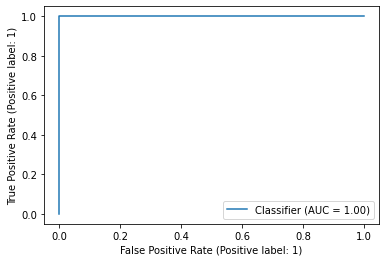

C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

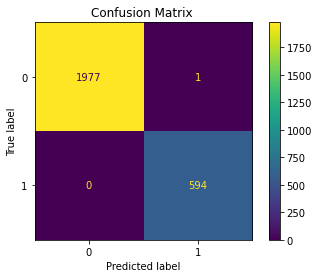

In [41]:
param_grid = {
    'reg__loss': ['hinge','log'],
    'reg__penalty':['l2', 'l1', 'elasticnet'],
    'reg__alpha': [0.0001, 0.001,0.01, 0.1]
}

model=trainmodel(SGDClassifier(),data_prep_pipeline,param_grid,'accuracy')
if(model.best_params_['reg__loss']=='hinge'):
    from sklearn.calibration import CalibratedClassifierCV
    cal=CalibratedClassifierCV(model, cv='prefit')
    model=trainmodel(cal,data_prep_pipeline,param_grid,'accuracy')
addresultotable(model,"SVD_LOG")
plotROC(model)
plotConf(model)
model_SVD_LOG=model
MODELS['SVD_LOG']=model_SVD_LOG

In [43]:
model.best_params_

{'reg__penalty': 'l2', 'reg__loss': 'log', 'reg__alpha': 0.0001}

In [42]:
expLog

,exp_name,Train Acc,Test Acc,Train AUC,Test AUC,Train F1,Test F1
0,XGB,0.9949,0.9938,0.9914,0.9913,0.9949,0.9938
1,SVD_LOG,0.9996,1.0000,0.9997,1.0000,0.9996,1.0000


# RandomForest

Fitting 5 folds for each of 10 candidates, totalling 50 fits


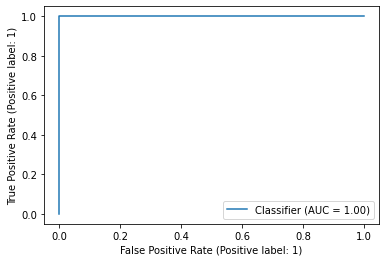

C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

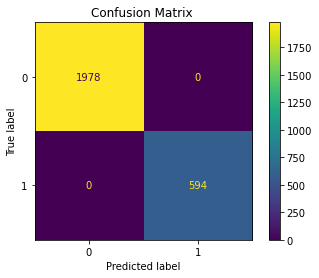

In [46]:
param_grid = {
    'reg__bootstrap': [True],
    'reg__max_depth': [10, 20,50,100],
    'reg__max_features': [2, 5,10,50],
    'reg__n_estimators': [100, 200,500]
}
model=trainmodel(RandomForestClassifier(),data_prep_pipeline,param_grid,'accuracy')
addresultotable(model,"RF")
model_RF=model
MODELS['RF']=model_RF
plotROC(model)
plotConf(model)

In [47]:
model.best_params_

{'reg__n_estimators': 500,
 'reg__max_features': 2,
 'reg__max_depth': 50,
 'reg__bootstrap': True}

In [48]:
expLog

,exp_name,Train Acc,Test Acc,Train AUC,Test AUC,Train F1,Test F1
0,XGB,0.9949,0.9938,0.9914,0.9913,0.9949,0.9938
1,SVD_LOG,0.9996,1.0000,0.9997,1.0000,0.9996,1.0000
2,RF,1.0000,0.9984,1.0000,0.9990,1.0000,0.9984


# KNN

Fitting 5 folds for each of 10 candidates, totalling 50 fits


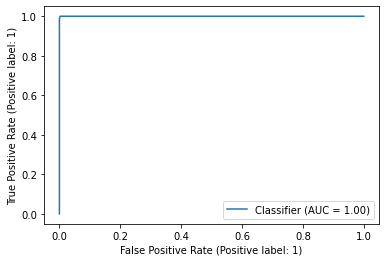

C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

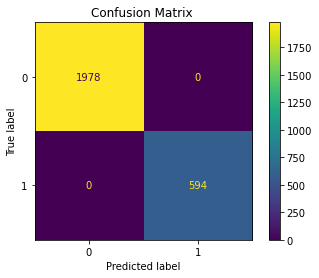

In [49]:
param_grid = {
    'reg__n_neighbors': [2,5,10],
    'reg__weights':['uniform', 'distance'],
    'reg__p': [1,2]
}
model=trainmodel(KNeighborsClassifier(),data_prep_pipeline,param_grid,'accuracy')
addresultotable(model,"KNN")
model_Knn=model
MODELS['Knn']=model_Knn
plotROC(model)
plotConf(model)

In [50]:
model.best_params_

{'reg__weights': 'distance', 'reg__p': 1, 'reg__n_neighbors': 2}

In [51]:
expLog

,exp_name,Train Acc,Test Acc,Train AUC,Test AUC,Train F1,Test F1
0,XGB,0.9949,0.9938,0.9914,0.9913,0.9949,0.9938
1,SVD_LOG,0.9996,1.0000,0.9997,1.0000,0.9996,1.0000
2,RF,1.0000,0.9984,1.0000,0.9990,1.0000,0.9984
3,KNN,1.0000,0.9969,1.0000,0.9933,1.0000,0.9969


# Best model predictions/

In [60]:
model_SVD_LOG = MODELS['SVD_LOG']

In [89]:
testdata = pd.read_csv("data/test_dataset.csv",index_col=False)


In [62]:
ytest=model_SVD_LOG.predict(testdata)

In [63]:
submission = pd.DataFrame({

        "ID": testdata["ID"],

        "Target": ytest

    })

In [64]:
submission.head(5)

,ID,Target
0,1.228840e+18,0
1,1.284940e+18,0
2,1.240280e+18,0
3,1.243150e+18,0
4,1.296620e+18,0


In [65]:
submission.to_csv('submission_SVDLOG.csv', index=False)

In [66]:
model = MODELS['RF']
ytest=model.predict(testdata)
submission = pd.DataFrame({

        "ID": testdata["ID"],

        "Target": ytest

    })
submission.to_csv('submission_RF.csv', index=False)

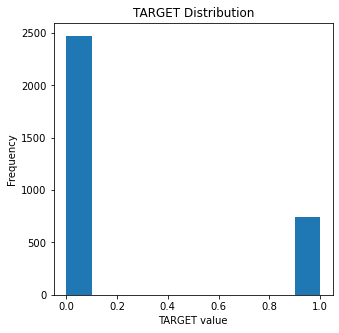

In [67]:
plt.figure(figsize=(5,5))
df['Target'].plot.hist(label=True);
plt.title('TARGET Distribution')
plt.xlabel('TARGET value')
plt.ylabel('Frequency');
plt.show()

In [90]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.head()

from sklearn.utils import resample

zerodata = train_data[train_data.Target==0]
onedata = train_data[train_data.Target==1]

default_sampled_data = resample(zerodata,
                          replace=True,
                          n_samples=int(len(onedata)*1.5), 
                          random_state=123) 

train_data = pd.concat([onedata, default_sampled_data])

train_data.Target.value_counts()

0    712
1    475
Name: Target, dtype: int64

In [92]:
y=train_data['Target']
X=train_data.drop(['Target'],axis=1)
print(X.shape,train_data.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

(1187, 34) (1187, 35)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\ensemble\_gb.py:1284: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  warnings.warn(
C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 a

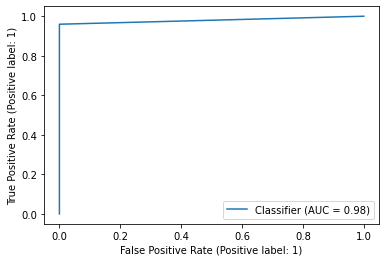

C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

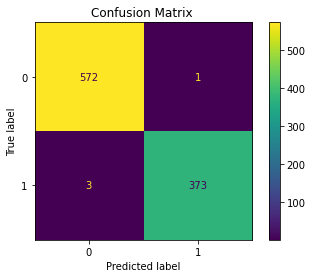

{'reg__subsample': 1.0,
 'reg__n_estimators': 50,
 'reg__min_samples_split': 0.13636363636363638,
 'reg__min_samples_leaf': 0.3545454545454546,
 'reg__max_features': 'log2',
 'reg__max_depth': 3,
 'reg__loss': 'deviance',
 'reg__learning_rate': 0.2,
 'reg__criterion': 'mae'}

In [93]:
parameters = {
    "reg__loss":["deviance"],
    "reg__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "reg__min_samples_split": np.linspace(0.1, 0.5, 12),
    "reg__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "reg__max_depth":[3,5,8],
    "reg__max_features":["log2","sqrt"],
    "reg__criterion": ["friedman_mse",  "mae"],
    "reg__subsample":[0.5,1.0],
    "reg__n_estimators":[10,50,100]
    }

model=trainmodel(GradientBoostingClassifier(),data_prep_pipeline,parameters,'accuracy')
addresultotable(model,"XGB_b")

plotROC(model)
plotConf(model)
model_XGB=model
MODELS['xgb_b']=model_XGB
model.best_params_

In [94]:
expLog

,exp_name,Train Acc,Test Acc,Train AUC,Test AUC,Train F1,Test F1
0,XGB,0.9949,0.9938,0.9914,0.9913,0.9949,0.9938
1,SVD_LOG,0.9996,1.0000,0.9997,1.0000,0.9996,1.0000
2,RF,1.0000,0.9984,1.0000,0.9990,1.0000,0.9984
3,KNN,1.0000,0.9969,1.0000,0.9933,1.0000,0.9969
4,XGB_b,0.9916,0.9933,0.9905,0.9916,0.9916,0.9933
5,SVD_LOG_b,0.9983,1.0000,0.9986,1.0000,0.9983,1.0000
6,SVD_LOG_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,SVD_LOG_b,1.0000,0.9966,1.0000,0.9958,1.0000,0.9966
8,RF_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,KNN_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


## SVD

Fitting 5 folds for each of 10 candidates, totalling 50 fits


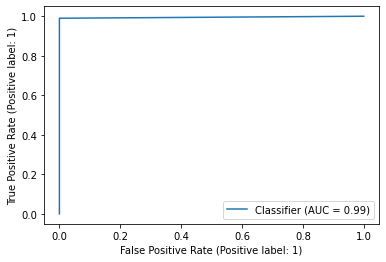

C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

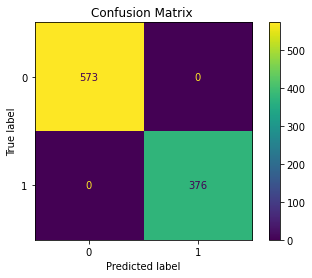

In [95]:
param_grid = {
    'reg__loss': ['hinge','log'],
    'reg__penalty':['l2', 'l1', 'elasticnet'],
    'reg__alpha': [0.0001, 0.001,0.01, 0.1]
}

model=trainmodel(SGDClassifier(),data_prep_pipeline,param_grid,'accuracy')
# if(model.best_params_['reg__loss']=='hinge'):
#     from sklearn.calibration import CalibratedClassifierCV
#     cal=CalibratedClassifierCV(model, cv='prefit')
#     model=trainmodel(cal,data_prep_pipeline,param_grid,'accuracy')
addresultotable(model,"SVD_LOG_b")
plotROC(model)
plotConf(model)
model_SVD_LOG=model
MODELS['SVD_LOG_b']=model_SVD_LOG

In [96]:
expLog

,exp_name,Train Acc,Test Acc,Train AUC,Test AUC,Train F1,Test F1
0,XGB,0.9949,0.9938,0.9914,0.9913,0.9949,0.9938
1,SVD_LOG,0.9996,1.0000,0.9997,1.0000,0.9996,1.0000
2,RF,1.0000,0.9984,1.0000,0.9990,1.0000,0.9984
3,KNN,1.0000,0.9969,1.0000,0.9933,1.0000,0.9969
4,XGB_b,0.9916,0.9933,0.9905,0.9916,0.9916,0.9933
5,SVD_LOG_b,0.9983,1.0000,0.9986,1.0000,0.9983,1.0000
6,SVD_LOG_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,SVD_LOG_b,1.0000,0.9966,1.0000,0.9958,1.0000,0.9966
8,RF_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,KNN_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [97]:
model.best_params_

{'reg__penalty': 'l2', 'reg__loss': 'log', 'reg__alpha': 0.001}

# RandomForest

Fitting 5 folds for each of 10 candidates, totalling 50 fits


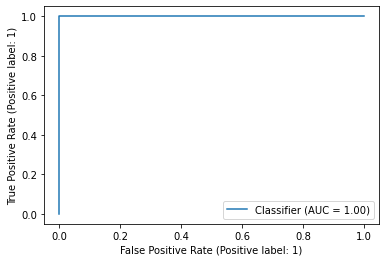

C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

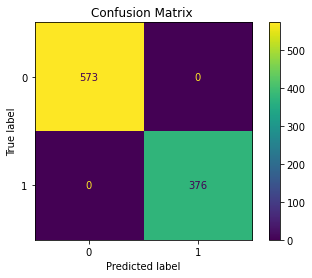

In [98]:
param_grid = {
    'reg__bootstrap': [True],
    'reg__max_depth': [10, 20,50,100],
    'reg__max_features': [2, 5,10,50],
    'reg__n_estimators': [100, 200,500]
}
model=trainmodel(RandomForestClassifier(),data_prep_pipeline,param_grid,'accuracy')
addresultotable(model,"RF_b")
model_RF=model
MODELS['RF_b']=model_RF
plotROC(model)
plotConf(model)

In [99]:
model.best_params_

{'reg__n_estimators': 200,
 'reg__max_features': 5,
 'reg__max_depth': 10,
 'reg__bootstrap': True}

In [100]:
expLog

,exp_name,Train Acc,Test Acc,Train AUC,Test AUC,Train F1,Test F1
0,XGB,0.9949,0.9938,0.9914,0.9913,0.9949,0.9938
1,SVD_LOG,0.9996,1.0000,0.9997,1.0000,0.9996,1.0000
2,RF,1.0000,0.9984,1.0000,0.9990,1.0000,0.9984
3,KNN,1.0000,0.9969,1.0000,0.9933,1.0000,0.9969
4,XGB_b,0.9916,0.9933,0.9905,0.9916,0.9916,0.9933
5,SVD_LOG_b,0.9983,1.0000,0.9986,1.0000,0.9983,1.0000
6,SVD_LOG_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,SVD_LOG_b,1.0000,0.9966,1.0000,0.9958,1.0000,0.9966
8,RF_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,KNN_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


# KNN

Fitting 5 folds for each of 10 candidates, totalling 50 fits


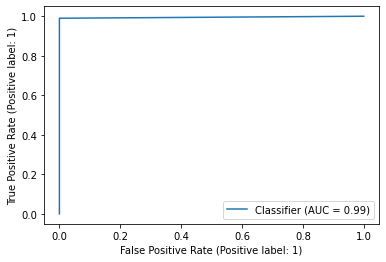

C:\Users\prath\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 432x288 with 0 Axes>

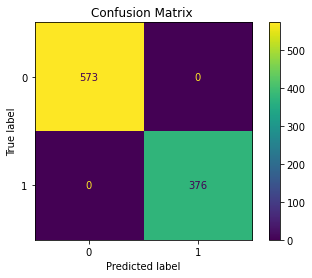

In [101]:
param_grid = {
    'reg__n_neighbors': [2,5,10],
    'reg__weights':['uniform', 'distance'],
    'reg__p': [1,2]
}
model=trainmodel(KNeighborsClassifier(),data_prep_pipeline,param_grid,'accuracy')
addresultotable(model,"KNN_b")
model_Knn=model
MODELS['Knn_b']=model_Knn
plotROC(model)
plotConf(model)

In [102]:
model.best_params_

{'reg__weights': 'distance', 'reg__p': 1, 'reg__n_neighbors': 2}

In [103]:
expLog

,exp_name,Train Acc,Test Acc,Train AUC,Test AUC,Train F1,Test F1
0,XGB,0.9949,0.9938,0.9914,0.9913,0.9949,0.9938
1,SVD_LOG,0.9996,1.0000,0.9997,1.0000,0.9996,1.0000
2,RF,1.0000,0.9984,1.0000,0.9990,1.0000,0.9984
3,KNN,1.0000,0.9969,1.0000,0.9933,1.0000,0.9969
4,XGB_b,0.9916,0.9933,0.9905,0.9916,0.9916,0.9933
5,SVD_LOG_b,0.9983,1.0000,0.9986,1.0000,0.9983,1.0000
6,SVD_LOG_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,SVD_LOG_b,1.0000,0.9966,1.0000,0.9958,1.0000,0.9966
8,RF_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,KNN_b,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [104]:
model = MODELS['RF_b']
ytest=model.predict(testdata)
submission = pd.DataFrame({

        "ID": testdata["ID"],

        "Target": ytest

    })
submission.to_csv('submission_RF_b.csv', index=False)


model = MODELS['Knn_b']
ytest=model.predict(testdata)
submission = pd.DataFrame({

        "ID": testdata["ID"],

        "Target": ytest

    })
submission.to_csv('submission_Knn_b.csv', index=False)

In [106]:
gc.collect()

15

In [108]:
!pip install --upgrade --user nltk

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [120]:
import nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import tree2conlltags

In [137]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
df2 = df
df2['tokTw'] = df2['full_text'].apply(word_tokenize).apply(pos_tag).apply(nltk.ne_chunk,args=(False,)).apply(tree2conlltags)

In [136]:
df2['tokTw'][4]

[('21', 'CD', 'O'),
 ('year', 'NN', 'O'),
 ('old', 'JJ', 'O'),
 ('palestinian', 'JJ', 'O'),
 ('woman', 'NN', 'O'),
 ('murdered', 'VBN', 'O'),
 ('by', 'IN', 'O'),
 ('her', 'PRP$', 'O'),
 ('brother', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('honor', 'NN', 'O'),
 ('killing', 'VBG', 'O'),
 ('-', ':', 'O'),
 ('anti', 'NN', 'O'),
 ('smite', 'JJ', 'O'),
 ('rashida', 'NN', 'O'),
 ('talib', 'NN', 'O'),
 ('blames', 'VBZ', 'O'),
 ('jews', 'NNS', 'O'),
 ('.', '.', 'O'),
 ('darn', 'VB', 'O'),
 ('jews', 'NNS', 'O'),
 ('get', 'VB', 'O'),
 ('away', 'RB', 'O'),
 ('with', 'IN', 'O'),
 ('everything', 'NN', 'O'),
 ('.', '.', 'O'),
 ('arnt', 'IN', 'O'),
 ('we', 'PRP', 'O'),
 ('lucky', 'VBP', 'O'),
 ('to', 'TO', 'O'),
 ('have', 'VB', 'O'),
 ('this', 'DT', 'O'),
 ('tool', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('congress', 'NN', 'O'),
 ('?', '.', 'O'),
 ('?', '.', 'O'),
 ('?', '.', 'O'),
 ('paint', 'NN', 'O'),
 ('my', 'PRP$', 'O'),
 ('country', 'NN', 'O'),
 ('red', 'VBD', 'O'),
 ('https', 'NN', 'O'),
 (':', ':', 'O'),
 (